In [36]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Perceptions

In [37]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # Petal length, petal width
y = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

print(y_pred)


[1]


In [38]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
print(x0.shape)
# print(x0[:4, :4])

print(x1.shape)
# print(x1[:4, :4])

print(x0.ravel().shape)
print(x1.ravel().shape)
# Concatenation along the second axis (column!)
X_new = np.c_[x0.ravel(), x1.ravel()]
print(X_new[:8, :])
print(f"X_new shape:{X_new.shape}")
y_pred = per_clf.predict(X_new)

zz = y_pred.reshape(x0.shape)


(200, 500)
(200, 500)
(100000,)
(100000,)
[[0.         0.        ]
 [0.01002004 0.        ]
 [0.02004008 0.        ]
 [0.03006012 0.        ]
 [0.04008016 0.        ]
 [0.0501002  0.        ]
 [0.06012024 0.        ]
 [0.07014028 0.        ]]
X_new shape:(100000, 2)


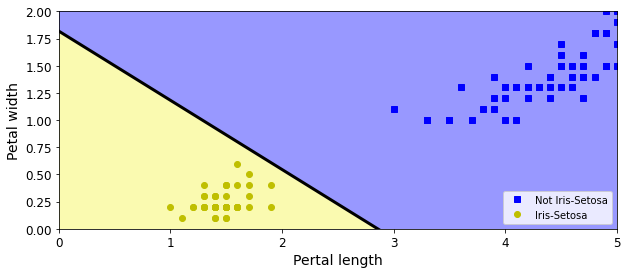

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris-Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#9898ff", "#fafab0"])
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.axis(axes)
plt.xlabel("Pertal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend()

plt.show()


## Activation Functions

In [40]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def relu(z):
    return np.maximum(0, z)


def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)


(200,)


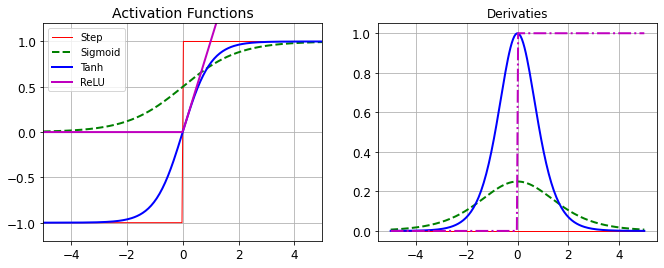

In [41]:
z = np.linspace(-5, 5, 200)
print(z.shape)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")

plt.grid(True)
plt.legend()
plt.title("Activation Functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")

plt.grid()
plt.title("Derivaties")

plt.show()


## Building an Image Classifier

In [42]:
import tensorflow as tf
from tensorflow import keras

In [43]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [44]:
print(X_train_full.shape)
print(X_train_full.dtype)

(60000, 28, 28)
uint8


In [45]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

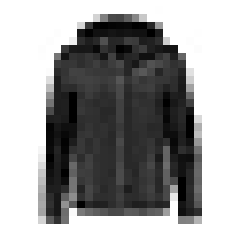

In [46]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

In [47]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

print(X_valid.shape)
print(X_test.shape)

assert class_names[y_train[0]] == "Coat"


(5000, 28, 28)
(10000, 28, 28)


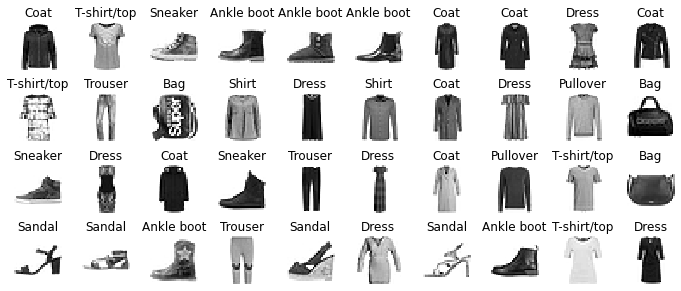

In [48]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


In [49]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))

# Output layer, should be classified into 10 classes
model.add(keras.layers.Dense(10, activation="softmax"))

print("")


In [50]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
print("* Layers of the model: ")
print(model.layers)

print("* Summary of the model:")
print(model.summary())

* Layers of the model: 
[<keras.layers.core.flatten.Flatten object at 0x7f7c77e9f3d0>, <keras.layers.core.dense.Dense object at 0x7f7c7462a920>, <keras.layers.core.dense.Dense object at 0x7f7be86185b0>, <keras.layers.core.dense.Dense object at 0x7f7bb83da530>]
* Summary of the model:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_23 (Dense)            (None, 300)               235500    
                                                                 
 dense_24 (Dense)            (None, 100)               30100     
                                                                 
 dense_25 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable p

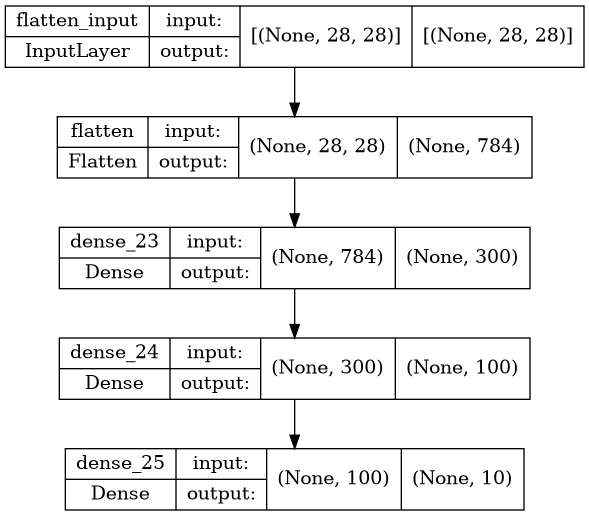

In [52]:
keras.utils.plot_model(model, "./images/my_fashion_mnist_model.png", show_shapes=True)


In [53]:
hidden1 = model.layers[1]
print(hidden1.name)

weights, biases = hidden1.get_weights()
print(weights.shape)
print(biases.shape)

dense_23
(784, 300)
(300,)


In [54]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)


In [55]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 18s 10ms/step - loss: 0.7013 - accuracy: 0.7691 - val_loss: 0.5178 - val_accuracy: 0.8200
Epoch 2/30
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4859 - accuracy: 0.8297 - val_loss: 0.4354 - val_accuracy: 0.8508
Epoch 3/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4429 - accuracy: 0.8436 - val_loss: 0.5404 - val_accuracy: 0.7976
Epoch 4/30
1719/1719 [==============================] - 20s 12ms/step - loss: 0.4166 - accuracy: 0.8550 - val_loss: 0.3952 - val_accuracy: 0.8642
Epoch 5/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3982 - accuracy: 0.8612 - val_loss: 0.3797 - val_accuracy: 0.8672
Epoch 6/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3794 - accuracy: 0.8664 - val_loss: 0.3735 - val_accuracy: 0.8710
Epoch 7/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3668 - accuracy: 0.8714 - val_loss: 0.3631 - val

In [56]:
print(history.params)

print(history.history.keys())

{'verbose': 1, 'epochs': 30, 'steps': 1719}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


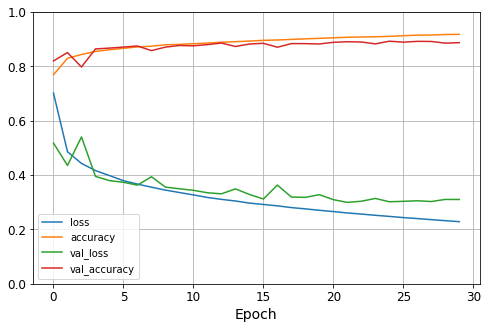

In [57]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid()
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epoch")
plt.show()

In [58]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.3410 - accuracy: 0.8790


[0.34096986055374146, 0.8790000081062317]

In [59]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
print(y_proba.round(2))

y_pred = np.argmax(model.predict(X_new), axis=-1)
print(y_pred)

ret = np.array(class_names)[y_pred]
print(ret)


[[0.   0.   0.   0.   0.   0.02 0.   0.02 0.   0.96]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']


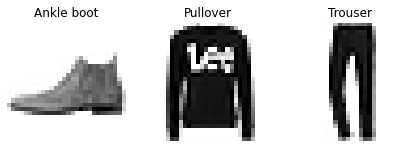

In [60]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


## Regression MLP

In [61]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)


In [62]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

print(X_train.shape)
print(X_train.shape[1:])

(11610, 8)
(8,)


In [63]:
import tensorflow.keras as keras

model = keras.models.Sequential(
    [
        # The number of features are X_train.shape[1:] == 8
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        # The output is a single neuron for a single value without activation function
        keras.layers.Dense(1),
    ]
)

model.compile(
    loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3)
)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
print("MSE on Test set:")
print(mse_test)


Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.6419 - val_loss: 0.8077
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7047 - val_loss: 0.6736
Epoch 3/20
363/363 [==============================] - 2s 4ms/step - loss: 0.6345 - val_loss: 0.6243
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5977 - val_loss: 0.5977
Epoch 5/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5706 - val_loss: 0.5708
Epoch 6/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5472 - val_loss: 0.5538
Epoch 7/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5288 - val_loss: 0.5370
Epoch 8/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5130 - val_loss: 0.5257
Epoch 9/20
363/363 [==============================] - 2s 4ms/step - loss: 0.4992 - val_loss: 0.5142
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4875 - val_loss: 0.5040

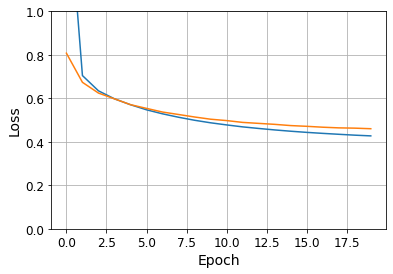

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history.history))
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epoch")
plt.gca().set_ylabel("Loss")
plt.grid()
plt.show()

## Functional API

In [65]:
np.random.seed(42)
tf.random.set_seed(42)


In [66]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input_], outputs=[output])


In [67]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 30)           930         ['dense_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_3[0][0]']            

In [68]:
model.compile(
    loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3)
)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
print("MSE Test:")
print(mse_test)


Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.2611 - val_loss: 0.7115
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6580 - val_loss: 0.6351
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5878 - val_loss: 0.5926
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5582 - val_loss: 0.5727
Epoch 5/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5347 - val_loss: 0.5501
Epoch 6/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5158 - val_loss: 0.5337
Epoch 7/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5002 - val_loss: 0.5209
Epoch 8/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4876 - val_loss: 0.5110
Epoch 9/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4760 - val_loss: 0.4997
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4659 - val_loss: 0.4907

In [69]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])


In [70]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit(
    (X_train_A, X_train_B),
    y_train,
    epochs=20,
    validation_data=((X_valid_A, X_valid_B), y_valid),
)
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))


Epoch 1/20
363/363 [==============================] - 2s 5ms/step - loss: 1.7643 - val_loss: 0.8370
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7584 - val_loss: 0.6888
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6584 - val_loss: 0.6248
Epoch 4/20
363/363 [==============================] - 2s 4ms/step - loss: 0.6023 - val_loss: 0.5923
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5663 - val_loss: 0.5607
Epoch 6/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5380 - val_loss: 0.5443
Epoch 7/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5187 - val_loss: 0.5283
Epoch 8/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5025 - val_loss: 0.5159
Epoch 9/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4889 - val_loss: 0.5097
Epoch 10/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4781 - val_loss: 0.4980

In [71]:
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
print("MSE result on test set:")
print(mse_test)

y_pred = model.predict((X_new_A, X_new_B))
print(y_pred)


162/162 [==============================] - 1s 3ms/step - loss: 0.4404
MSE result on test set:
0.44039714336395264
[[0.24839205]
 [1.9652917 ]
 [3.6368716 ]]


#### Adding an auxiliary output for regulation

In [78]:
np.random.seed(42)
tf.random.set_seed(42)

In [79]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
# Add both inputs and outputs to the model
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])


In [80]:
model.compile(
    # Both outputs use the MSE as the loss function
    loss=["mse", "mse"],
    # The main output is given a higher weight !!!
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
)


In [81]:
history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]),
)


Epoch 1/20
363/363 [==============================] - 3s 6ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 2s 6ms/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 2s 6ms/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - val_loss

In [86]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
print(y_pred_main)
print(y_pred_aux)

162/162 [==============================] - 1s 4ms/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082
[[0.26762432]
 [1.980763  ]
 [3.3396285 ]]
[[0.9593649]
 [1.9240992]
 [2.5152812]]


## The Sub-classing API

In [87]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [88]:
model.compile(
    loss="mse",
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
)

history = model.fit(
    (X_train_A, X_train_B),
    (y_train, y_train),
    epochs=10,
    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)),
)

total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))
print(y_pred_main)
print(y_pred_aux)

Epoch 1/10
363/363 [==============================] - 2s 5ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 2s 4ms/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 2s 6ms/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

## Saving and Restoring

In [89]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
	keras.layers.Dense(30, activation="relu", input_shape=[8]),
	keras.layers.Dense(30, activation="relu"),
	keras.layers.Dense(1)
])

In [90]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
print(mse_test)

Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 2s 4ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 2s 6ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 2s 7ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 2s 7ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 2s 7ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 2s 6ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 1s 5ms/step - loss: 0.4382
0.4382286965847015

In [91]:
model.save("./models/my_keras_model.h5")

In [94]:
model = keras.models.load_model("./models/my_keras_model.h5")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                270       
                                                                 
 dense_7 (Dense)             (None, 30)                930       
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________


In [97]:
model.save_weights("./models/my_keras_model_weights.ckpt")

model.load_weights("./models/my_keras_model_weights.ckpt")

## Using Callbacks during Training

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=[8]),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1),
    ]
)

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "./models/my_keras_model_callback.h5", save_best_only=True
)
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb],
)

best_model = keras.models.load_model("./models/my_keras_model_callback.h5")
mse_test = best_model.evaluate(X_test, y_test)
print("MSE of the test set:")
print(mse_test)

Epoch 1/10
363/363 [==============================] - 2s 5ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 2s 5ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 2s 4ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 2s 6ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 2s 4ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 2s 4ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 1s 4ms/step - loss: 0.4382
MSE of the test se

In [102]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb],
)

mse_test = best_model.evaluate(X_test, y_test)
print("MSE of the test set:")
print(mse_test)


Epoch 1/5
363/363 [==============================] - 2s 4ms/step - loss: 0.3562 - val_loss: 0.3580
Epoch 2/5
363/363 [==============================] - 1s 4ms/step - loss: 0.3554 - val_loss: 0.3649
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.3546 - val_loss: 0.3505
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.3539 - val_loss: 0.3390
Epoch 5/5
162/162 [==============================] - 1s 3ms/step - loss: 0.4382
MSE of the test set:
0.43822869658470154


In [103]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))


In [104]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    X_train,
    y_train,
    epochs=3,
    validation_data=(X_valid, y_valid),
    callbacks=[val_train_ratio_cb],
)


Epoch 1/3
362/363 [============================>.] - ETA: 0s - loss: 0.3516
val/train: 1.00
363/363 [==============================] - 2s 5ms/step - loss: 0.3522 - val_loss: 0.3521
Epoch 2/3
352/363 [============================>.] - ETA: 0s - loss: 0.3517
val/train: 1.04
363/363 [==============================] - 1s 4ms/step - loss: 0.3515 - val_loss: 0.3646
Epoch 3/3
357/363 [============================>.] - ETA: 0s - loss: 0.3505
val/train: 0.99
363/363 [==============================] - 1s 4ms/step - loss: 0.3509 - val_loss: 0.3480


## TensorBoard

In [107]:
root_logdir = os.path.join(os.curdir, "logs")


def get_run_logdir():
    import time

    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()
run_logdir

'./logs/run_2022_03_23-22_59_19'

In [109]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [110]:
model = keras.models.Sequential([
	keras.layers.Dense(30, activation="relu", input_shape=[8]),
	keras.layers.Dense(30, activation="relu"),
	keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [111]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, tensorboard_cb],
)


Epoch 1/30
363/363 [==============================] - 2s 6ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 2s 6ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 2s 4ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 2s 6ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 2s 4ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 2s 4ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 2s 4ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 2s 4ms/step - loss: 0.4474 - val_loss: 0.4379

In [112]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

## Hyperparameter Tuning

In [114]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [115]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    # The output layer
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


In [116]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

keras_reg.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)


Epoch 1/10


/tmp/ipykernel_597032/2914051717.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


363/363 [==============================] - 2s 6ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/10
363/363 [==============================] - 2s 4ms/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/10
363/363 [==============================] - 2s 4ms/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/10
363/363 [==============================] - 2s 4ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4060 - val_loss: 0.4071


In [120]:
mse_test = keras_reg.score(X_test, y_test)
X_new = X_test[:3]
y_pred = keras_reg.predict(X_new)
print(y_pred)

162/162 [==============================] - 1s 4ms/step - loss: 0.3998
[0.562418  1.7254481 3.293423 ]


In [126]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

para_distribs = {
    "n_hidden": [2],
    "n_neurons": [42],
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(10000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, para_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(
    X_train,
    y_train,
    epochs=3,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/3
242/242 [==============================] - 2s 6ms/step - loss: 2.3992 - val_loss: 1.3513
Epoch 2/3
242/242 [==============================] - 2s 6ms/step - loss: 0.9524 - val_loss: 0.8133
Epoch 3/3
121/121 [==============================] - 0s 3ms/step - loss: 0.6881
[CV] END learning_rate=0.0008342835310183467, n_hidden=2, n_neurons=42; total time=   5.1s
Epoch 1/3
242/242 [==============================] - 2s 6ms/step - loss: 2.6883 - val_loss: 1.7046
Epoch 2/3
242/242 [==============================] - 1s 6ms/step - loss: 0.9887 - val_loss: 1.5840
Epoch 3/3
121/121 [==============================] - 0s 4ms/step - loss: 0.7749
[CV] END learning_rate=0.0008342835310183467, n_hidden=2, n_neurons=42; total time=   5.0s
Epoch 1/3
242/242 [==============================] - 2s 6ms/step - loss: 2.7750 - val_loss: 1.3938
Epoch 2/3
242/242 [==============================] - 1s 5ms/step - loss: 1.1132 - val_loss: 0.9233
Epo

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f7b8138bc70>,
                   param_distributions={'learning_rate': [0.029382074160400024,
                                                          0.010544797366053075,
                                                          0.004336519363329427,
                                                          0.000611412185779229,
                                                          0.0032203805686750364,
                                                          0.0009984785429644051,
                                                          0.0009588845117570671,
                                                          0.013682950425728257,
                                                          0.0017314505897454231,
                                                          0.0023909410116215...
                                                          0.01369842188

In [127]:
# This is not the correct search space... Just to show how it works.
# The correct search space could take hours to run...
print(rnd_search_cv.best_params_)

{'n_neurons': 42, 'n_hidden': 2, 'learning_rate': 0.014492776410523284}
